In [1]:
import os
import pandas as pd
from yellowbrick.style import set_palette
set_palette('flatui')
import seaborn as sns
colours = ['#34495E', 'seagreen']

In [2]:
path_to_files = 'datasets_extracted/'
datasets = os.listdir(path_to_files)

subset = datasets[-1]

print("Selected: ",subset)

Selected:  Twyford_railway_station-2023-12-02_09-05-35


In [3]:
filter=['time','x','y','z']

In [4]:
from pandas.errors import EmptyDataError

In [35]:
def parseDataset(subset):
    path_to_files = 'datasets_extracted/'
    acc = '/AccelerometerUncalibrated.csv'
    gyro= '/GyroscopeUncalibrated.csv'
    mag = '/MagnetometerUncalibrated.csv'
    gps = '/Location.csv'
    metadata = pd.read_csv(path_to_files+subset+'/Metadata.csv')
    metadata.to_dict()

    print("Processing: ",subset)
    data = {
        'acc':pd.read_csv(path_to_files+subset+acc),
        'gyro':pd.read_csv(path_to_files+subset+gyro),
        'mag':pd.read_csv(path_to_files+subset+mag)
    }

    try:
        data_gps = pd.read_csv(path_to_files+subset+gps) 
    except EmptyDataError as e:
        print("No rows in GPS")
        return [pd.DataFrame(),pd.DataFrame()]

    data_df = pd.merge(data['acc'][filter],data['gyro'][filter],on='time',suffixes=("_acc", "_gyro"),how='outer')
    data_df = pd.merge(data_df,data['mag'][filter],on='time',how='outer')
    data_df = data_df.rename(columns={'x':'x_mag','y':'y_mag','z':'z_mag'})
    data_df

    data_df.sort_values(by='time',inplace=True)

    # Convert time columns to datetime objects
    data_df['time'] = pd.to_datetime(data_df['time'])
    data_gps['time'] = pd.to_datetime(data_gps['time'])

    # Set a time tolerance (adjust as needed)
    time_tolerance = pd.Timedelta('1 second')

    # Merge based on the closest timestamp with a tolerance
    data_gps_scaled = pd.merge_asof(data_df.time, data_gps, on='time', tolerance=time_tolerance)

    # BFill and FFill
    df_filled = data_df.fillna(method='ffill').fillna(method='bfill')
    # data_gps_filled = data_gps_scaled.fillna(method='ffill').fillna(method='bfill')
    # df_filled = data_df.interpolate()
    data_gps_filled = data_gps_scaled.interpolate()
    # data_gps_filled = data_gps_filled.fillna(0)

    df_filled['longitude'] = data_gps_filled['longitude']
    df_filled['latitude'] = data_gps_filled['latitude']

    df_filled['time'] = pd.to_datetime(df_filled['time'])
    df_filled['time'] = df_filled['time'].astype('int64')

    df_filled['longitude_delta'] = df_filled['longitude'].diff() # Note to self:Move this step before interpolation to maybe yeild more better results
    df_filled['latitude_delta'] = df_filled['latitude'].diff()

    df_filled = df_filled.dropna()
    
    df_filled = df_filled.drop_duplicates(subset=['x_acc', 'y_acc', 'z_acc', 'x_gyro', 'y_gyro', 'z_gyro','latitude','longitude'])

    os.makedirs('datasets/'+subset,exist_ok=True)

    df_filled.to_csv('datasets/'+subset+'/observations.csv',index=False)
    # data_gps_filled.to_csv('datasets/'+subset+'/gps.csv',index=False)
    print("Processed",subset," Rows:",df_filled.shape[0])
    df_filled['source'] = subset
    # data_gps_filled['source'] = subset
    # return [df_filled,data_gps_filled]
    return df_filled


In [36]:
existing = os.listdir('datasets/')
existing = []

In [37]:
global_dataset_imu = pd.DataFrame()
# global_dataset_gps = pd.DataFrame()

In [38]:
for file in datasets[:]:
    if('.csv' in file) or (file in existing):
        print("Skip",file)
        continue

    _imu = parseDataset(file)
    global_dataset_imu = pd.concat([global_dataset_imu,_imu], ignore_index = True, sort=False)
    # global_dataset_gps = pd.concat([global_dataset_gps,_gps], ignore_index = True, sort=False)
print("Complete")

Processing:  2023-04-02_19-22-16
Processed 2023-04-02_19-22-16  Rows: 1466434
Processing:  2023-04-19_07-21-10
Processed 2023-04-19_07-21-10  Rows: 733406
Processing:  2023-04-21_17-03-28
Processed 2023-04-21_17-03-28  Rows: 172323
Processing:  2023-06-02_06-34-39
Processed 2023-06-02_06-34-39  Rows: 19783
Processing:  2023-06-02_12-14-13
Processed 2023-06-02_12-14-13  Rows: 11674
Processing:  2023-06-02_13-28-32
Processed 2023-06-02_13-28-32  Rows: 3138
Processing:  2023-06-03_06-13-40
Processed 2023-06-03_06-13-40  Rows: 2170
Processing:  2023-06-03_07-09-39
Processed 2023-06-03_07-09-39  Rows: 46867
Processing:  2023-07-05_07-44-33
Processed 2023-07-05_07-44-33  Rows: 15664
Processing:  2023-07-26_06-26-10
Processed 2023-07-26_06-26-10  Rows: 89430
Processing:  Earley-2023-12-08_07-39-28
Processed Earley-2023-12-08_07-39-28  Rows: 976
Processing:  Forbury_Road-2023-12-15_07-55-45
Processed Forbury_Road-2023-12-15_07-55-45  Rows: 270204
Processing:  Forbury_Road_(stop_EL)-2023-11-28_

In [39]:
global_dataset_imu.to_csv('global_observations.csv',index=False)
# global_dataset_gps.to_csv('datasets/global_gps.csv',index=False)

In [12]:
global_dataset_imu.shape

(2551082, 11)

In [13]:
global_dataset_gps.shape

(2551082, 12)

<Axes: >

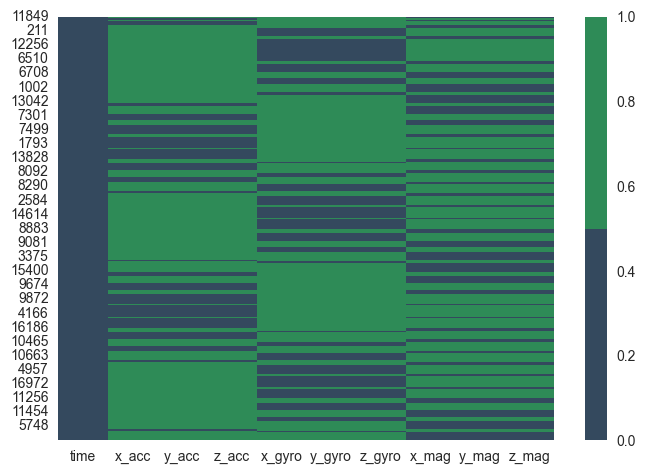

In [17]:
# sns.heatmap(data_df.isnull(), cmap=sns.color_palette(colours))

<Axes: >

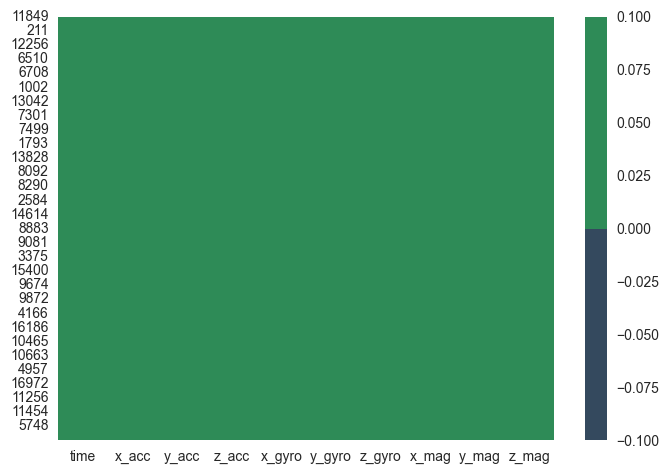

In [20]:
sns.heatmap(df_filled.isnull(), cmap=sns.color_palette(colours))

In [21]:
os.makedirs('datasets/'+subset,exist_ok=True)

In [22]:
df_filled.to_csv('datasets/'+subset+'/combined_sensors.csv',index=False)
data_gps_filled.to_csv('datasets/'+subset+'/gps.csv',index=False)